In [52]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from scipy.optimize import curve_fit
from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [53]:
scan_name ="XAS-L-cystine-timescan"
scan_range = ".run002525-002545"

DIR = "/sf/alvra/data/p18387/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p18387/res/scan_info/"


!ls -lah -rt $DIR | grep BSREAD
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

-rw-r--r--  1 root p18387 531M Feb 22 20:55 run_002018.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 20:55 run_002018.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 20:56 run_002019.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 20:56 run_002019.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 20:57 run_002020.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 20:57 run_002020.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 20:57 run_002021.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 20:57 run_002021.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 20:58 run_002022.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 20:58 run_002022.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 20:59 run_002023.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 20:59 run_002023.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 21:00 run_002024.BSREAD.h5
-rw-r--r--  1 root p18387 652M Feb 22 21:00 run_002024.BSREAD.IMAGES.h5
-rw-r--r--  1 root p18387 531M Feb 22 21:

sf-cn-1.psi.ch
There are 360 files in the folder /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/


# Load one file and check signal levels

In [69]:
#f ="RuDimerACN_monoscan_0p6ps_018_step0003.BSREAD.h5"
f ="run_002525.BSREAD.h5"
fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(fn, channel_energy)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()

print ("Energy {} eV".format(Energy_shot.mean()))

conditionGeneral_pump = IzeroFEL_pump_shot > 0.1
conditionGeneral_unpump = IzeroFEL_unpump_shot > 0.1

med_pump = np.median(IzeroFEL_pump_shot)
std_pump = np.std(IzeroFEL_pump_shot)
conditionPumpMax = IzeroFEL_pump_shot < med_pump+3*std_pump
conditionPumpMin = IzeroFEL_pump_shot > med_pump-3*std_pump

med_pump = np.median(IzeroFEL_unpump_shot)
std_pump = np.std(IzeroFEL_unpump_shot)
conditionUnPumpMax = IzeroFEL_unpump_shot < med_pump+3*std_pump
conditionUnPumpMin = IzeroFEL_unpump_shot > med_pump-3*std_pump

# DataFluo_pump_shot_norm = DataFluo_pump_shot_original / IzeroFEL_pump_original
# med_pump_corr = np.avg(DataFluo_pump_shot_norm)
# std_pump_corr = np.std(DataFluo_pump_shot_norm)

# DataFluo_unpump_shot_norm = DataFluo_unpump_shot_original / IzeroFEL_unpump_original
# med_unpump_corr = np.avg(DataFluo_unpump_shot_norm)
# std_unpump_corr = np.std(DataFluo_unpump_shot_norm)

# conditionCorr = 

condition = conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral_pump & conditionGeneral_unpump
IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition]

DataFluo_pump_shot = DataFluo_pump_shot[condition]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)

print (IzeroFEL_pump_original.shape, IzeroFEL_unpump_original.shape)
print (IzeroFEL_pump_shot.shape, IzeroFEL_unpump_shot.shape)

print ("Median value Izero = {}".format(np.median(IzeroFEL_pump_shot)))# - 2*(np.std(IzeroFEL_pump_shot))
print ("Median value fluo = {}".format(np.median(DataFluo_pump_shot)))# - 2*(np.std(IzeroFEL_pump_shot)))

Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 999 shots each
Energy 2466.5046574691946 eV
(999,) (999,)
(806,) (806,)
Median value Izero = 0.2700100280344486
Median value fluo = 0.12603759765625


<IPython.core.display.Javascript object>


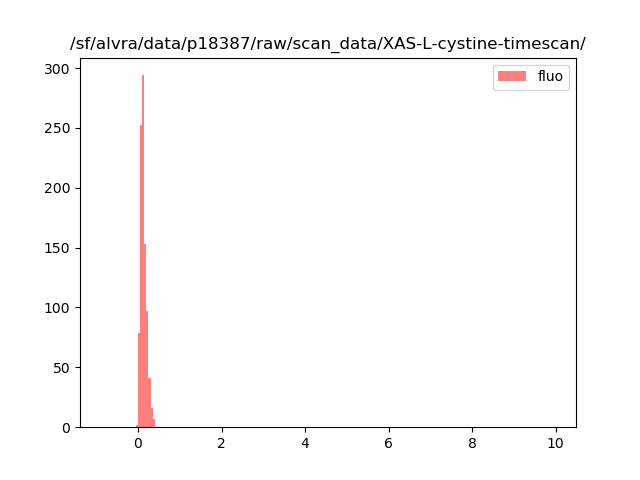

0.11932373046875


In [55]:
#num_bins = 100
plt.figure()
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.85,10,0.05), facecolor='red', label="fluo", alpha=0.5)
print (np.median(DataFluo_pump_shot))
#plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.legend(loc="best")
plt.title(DIR)
plt.show()
#print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

<IPython.core.display.Javascript object>


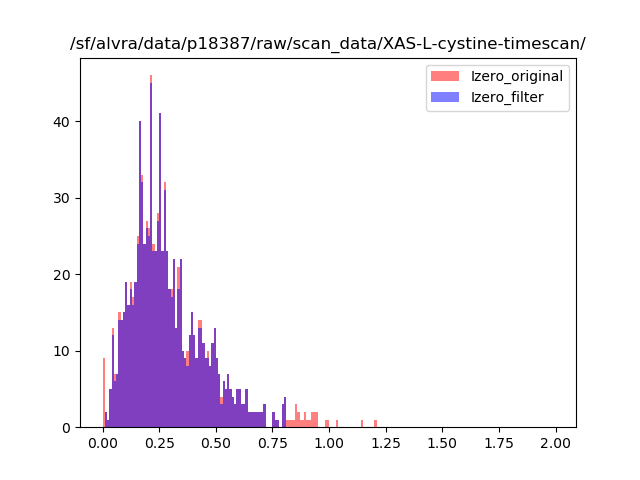

0.2544102892279625


In [56]:
#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_pump_original, bins =np.arange(0,2,0.01), facecolor='red', label='Izero_original', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,2,0.01), facecolor='blue', label='Izero_filter', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.legend(loc="best")
plt.title(DIR)
plt.show()
print (np.median(IzeroFEL_pump_shot))

<IPython.core.display.Javascript object>


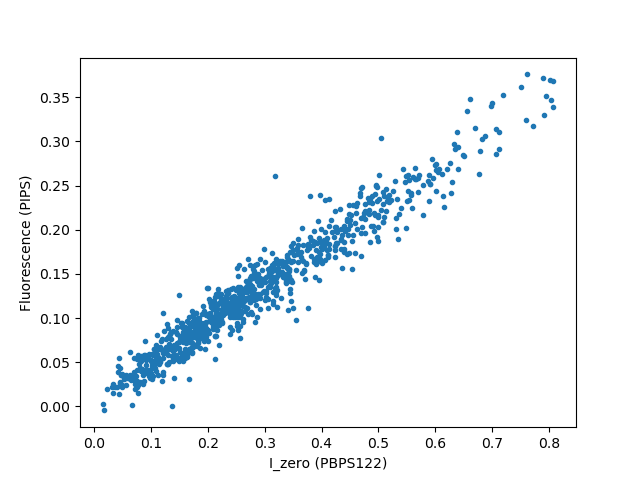

In [57]:
plt.figure()

plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot,  linestyle='None', label="correlation",marker='.')

plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")
#plt.ylim((-1,1))
#plt.xlim((-1,1))

plt.show()

<IPython.core.display.Javascript object>


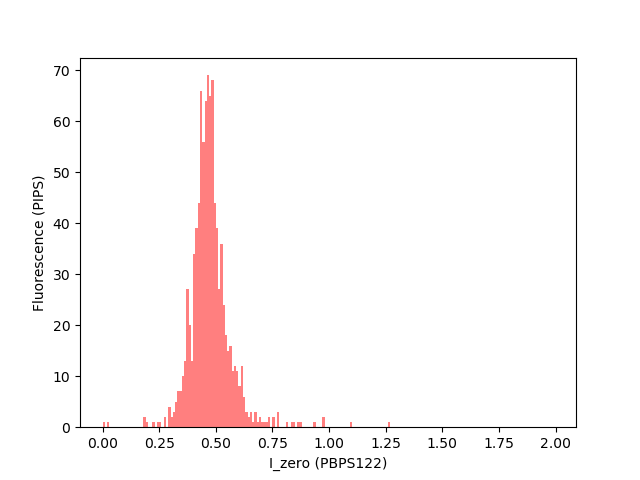

In [61]:
plt.figure()

plt.hist(DataFluo_pump_shot / IzeroFEL_pump_shot, bins =np.arange(0,2,0.01), facecolor='red', label='Izero_original', alpha=0.5)

plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")
#plt.ylim((-1,1))
#plt.xlim((-1,1))

plt.show()

# Load time scan

In [50]:
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 51

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:  #and i!=3:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(filename, channel_delay)
        
        threshold_pump = IzeroFEL_pump_shot > 0.05
        threshold_unpump = IzeroFEL_unpump_shot > 0.05
        condition_pump = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-3*(np.std(IzeroFEL_pump_shot))
        condition_unpump = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-3*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
              
        DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
    
    
              
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        DataTrans_pump_shot_norm = DataTrans_pump_shot / IzeroFEL_pump_shot
        DataTrans_unpump_shot_norm = DataTrans_unpump_shot / IzeroFEL_unpump_shot
              
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        DataFluo_pump.append(DataFluo_pump_shot_norm.mean())
        DataFluo_unpump.append(DataFluo_unpump_shot_norm.mean())
        DataTrans_pump.append(DataTrans_pump_shot_norm.mean())
        DataTrans_unpump.append(DataTrans_unpump_shot_norm.mean())
        
        Pump_probe.append(Pump_probe_shot.mean())
        
        err_DataFluo_pump.append(DataFluo_pump_shot_norm.std()/np.sqrt(DataFluo_pump_shot_norm.size))
        err_DataFluo_unpump.append(DataFluo_unpump_shot_norm.std()/np.sqrt(DataFluo_unpump_shot_norm.size))
        err_DataTrans_pump.append(DataTrans_pump_shot_norm.std()/np.sqrt(DataTrans_pump_shot_norm.size))
        err_DataTrans_unpump.append(DataTrans_unpump_shot_norm.std()/np.sqrt(DataTrans_unpump_shot_norm.size))
              
        err_Pump_probe.append(Pump_probe_shot.std()/np.sqrt(Pump_probe_shot.size))
               
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
DataTrans_pump = np.asarray(DataTrans_pump)
DataTrans_unpump = np.asarray(DataTrans_unpump)
              
Pump_probe = np.asarray(Pump_probe)
err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
err_DataTrans_pump = np.asarray(err_DataTrans_pump)
err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Delay_mm = np.asarray(Delay_mm)

print ("Job done!")


/sf/alvra/data/p18387/res/scan_info/XAS-L-cystine-timescan.run002525-002545.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002525.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 999 shots each
step 2 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002526.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 998 shots each
step 3 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002527.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 999 shots each
step 4 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002528.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 998 shots each
step 5 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002529.BSREAD.h5
Found 3999 shots in the file
Load

# Plot time scans

<IPython.core.display.Javascript object>


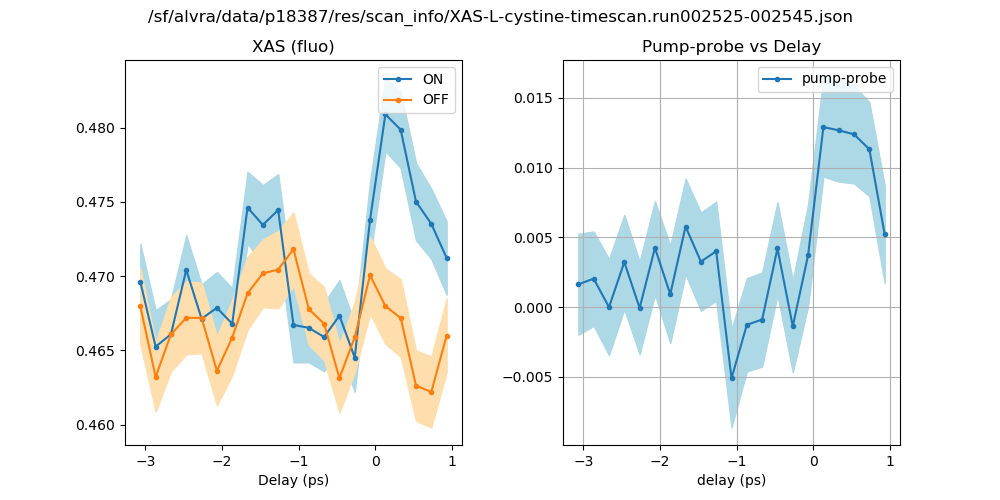

In [51]:
#Timezero = 141.36   # position of Timezero on PP delay (in mm!)
#Timezero = 160.0317   # position of Timezero on PP delay (in mm!)
Timezero = 177.51 # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !
#Delay_ps = Delay_mm
scale=1

#offset_corr_DataFluo_pump = scale*DataFluo_pump - np.mean(scale*DataFluo_pump[:3])
#offset_corr_DataFluo_unpump = scale*DataFluo_unpump - np.mean(scale*DataFluo_unpump[:3])
#offset_corr_pump_probe = offset_corr_DataFluo_pump - offset_corr_DataFluo_unpump


plt.figure(figsize = (10,5))
plt.suptitle(json_file, fontsize=12)

#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Delay_ps, scale*DataFluo_pump, label="ON",marker='.')
plt.plot(Delay_ps, scale*DataFluo_unpump, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Delay_ps, scale*(Pump_probe), label="pump-probe",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("delay (ps)")
plt.gca().set_title('Pump-probe vs Delay')
plt.legend(loc="best")

plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

In [35]:
Pump_probe_tofit = (Pump_probe).copy()
Delay_mm_tofit = Delay_mm.copy()
Delay_ps_tofit = Delay_ps.copy()

In [36]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])

print("Position t0 =",np.round(parameters[2],5),"mm")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"um")

Position t0 = 1.01942 mm
Width = 67.0 um


<IPython.core.display.Javascript object>


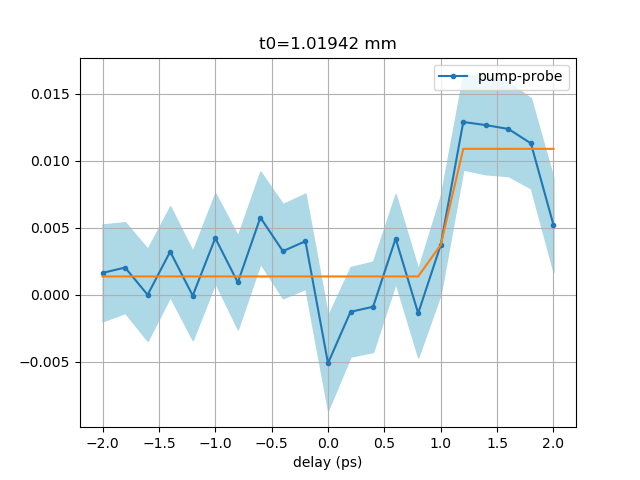

Text(0.5, 1.0, 't0=1.01942 mm')

In [37]:
#... and the plot with the fit curve

plt.figure()

plt.plot(Delay_ps_tofit, Pump_probe_tofit, label="pump-probe",marker='.')
plt.fill_between(Delay_ps_tofit, low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters))
plt.grid()
plt.xlabel("delay (ps)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(parameters[2], 5)) + ' mm' )


#plt.plot(Delay_ps_tofit, Pump_probe_tofit, label=f"{scan_name}",marker='.')


#low_err = Pump_probe_tofit - err_pump_probe
#high_err = Pump_probe_tofit + err_pump_probe
#plt.fill_between(np.squeeze(Delay_ps), low_err_pumpprobe, high_err_pumpprobe, color='lightblue')

#plt.fill_between(Delay_ps_toFit, low_err, high_err, color='lightblue')
#plt.savefig(savedir + 'scan_YAG_007')

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])

print("Position t0 =",np.round(parameters[2],5),"ps")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

In [ ]:
#... and the plot with the fit curve

plt.figure()

plt.plot(Delay_ps_tofit, Pump_probe_tofit, label=f"{scan_name}",marker='.')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters))

#low_err = Pump_probe_tofit - err_pump_probe
#high_err = Pump_probe_tofit + err_pump_probe
#plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
plt.title('width=' + str(np.round(parameters[3]*1000, 5)) + ' fs' )
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [ ]:
timelist=np.concatenate((np.arange(-1.5,-0.5-1,-1))-, np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

In [ ]:
def exponential_func(x,a,b,c):
    return a*np.exp(-b*x)+c

def bi_exponential_func(x,a,b,c, d, e):
    return a*np.exp(-b*x)+c+d*np.exp(-e*x)

Delay_ps = np.array(Delay_ps)
t_range = Delay_ps > 0.02 

popt,pcov = curve_fit(exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 10, 0.2))
popt2,pcov2 = curve_fit(bi_exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 0.6, 0.2, 0.4, 6))

xx= np.linspace(0, 20, 100)
yy = exponential_func(xx, *popt)
yyy= bi_exponential_func(xx, *popt2)

plt.figure()
plt.plot(Delay_ps, -Pump_probe)
plt.plot(xx, yy)
plt.plot(xx, yyy)


print(popt)
print(popt2)
